In [1]:
import torch
import doubleauction
import numpy as np

In [2]:
from doubleauction.util import OrnsteinUhlenbeckProcess

# Create environment

In [3]:
import matplotlib.pyplot as plt

In [4]:
import doubleauction
from doubleauction.agents import RandomSeller, RandomBuyer, DDPGSellerOU
from doubleauction.environments import MarketEnvironment

from doubleauction.matchers import RandomMatcher

from doubleauction.util import SequentialMemory, hard_update, soft_update
from doubleauction.util import generate_seller_prices_paper, generate_buyer_prices_paper

In [5]:
seller_agent = DDPGSellerOU('learner', 0, 
                                ou_theta=.7, ou_mu=.0, ou_sigma=15., sigma_min=3.5, anneal_steps=300*10*10,
                                  discount = 0.97, lr = 3e-4, 
                                  wd = 1e-4, mem_size=500000, tau=5e-3)

seller_agent.eval = True

# Model 2

In [6]:
mdict = torch.load('results/models_ou2')
seller_agent.actor.load_state_dict(mdict['actor'])
seller_agent.actor_target.load_state_dict(mdict['actor_target'])

seller_agent.critic.load_state_dict(mdict['critic'])
seller_agent.critic_target.load_state_dict(mdict['critic_target'])

<All keys matched successfully>

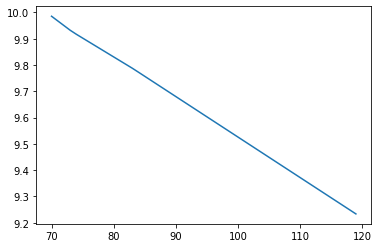

In [7]:
offers = []
with torch.no_grad():
    for i in range(70, 120):
#         self.state = np.array([self.last_demand, self.last_successful,
#                                self.game_first, self.round_first,
#                                self.reservation_price], dtype=np.float)
        state = np.array([0., 0., 1., 1., i/200], dtype=np.float)
        state = torch.tensor(state).float()
        
        seller_agent.actor.eval()
        o = seller_agent.actor(state)

        offers.append(o.item())
    
plt.figure()
plt.plot(range(70, 120), offers)

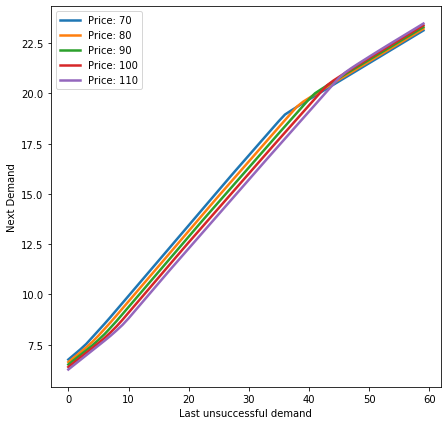

In [8]:
plt.figure(figsize=(7,7))
for price in [70, 80, 90, 100, 110]:
    offers = []
    with torch.no_grad():
        for i in range(0, 60):
    #         self.state = np.array([self.last_demand, self.last_successful,
    #                                self.game_first, self.round_first,
    #                                self.reservation_price], dtype=np.float)
            state = np.array([i/50., 0., 0., 0., price/200.], dtype=np.float)
            state = torch.tensor(state).float()

            seller_agent.actor.eval()
            o = seller_agent.actor(state)
            offers.append(o.item())

    plt.plot(range(0, 60), offers, label='Price: ' + str(price), linewidth=2.5)
    
plt.legend()
plt.ylabel('Next Demand')
plt.xlabel('Last unsuccessful demand');

In [9]:
epochs = 15

price_reward_data = []
offer_data = []

for e in range(epochs):
    seller_agent.reservation_price = generate_seller_prices_paper(1)[0]
    
    sellers = []
    for ii, p in enumerate(generate_seller_prices_paper(19)):
        sellers.append(RandomSeller('s'+str(ii), p))
    sellers.append(seller_agent)

    buyers = []
    for ii, p in enumerate(generate_buyer_prices_paper(20)):
        buyers.append(RandomBuyer('b'+str(ii), p))

    agents = sellers + buyers
    
    seller_agent.new_game()

    
    ROUNDS_PER_GAME = 10

    market_env = MarketEnvironment(sellers=sellers, buyers=buyers, max_time=10, ## not the same as rounds per game!!
                                   matcher=RandomMatcher(reward_on_reference=True))
    init_observation = market_env.reset()

    round_avg = 0.
    offer_avg = 0.
    time_avg = 0.

    game_offers = []

    for n_round in range(10):
        round_process_vs_rewards = {a.agent_id:[a.reservation_price, 0] for a in agents}
        
        init_observation = market_env.reset()
        observations = {k.agent_id:None for k in agents}
        done = {k.agent_id:False for k in agents}
        reward_hist = []
        rounds = 0
        terminate_round = False
        
        seller_agent.new_round()
        
        offers_list = []
        
        while not terminate_round:
            offers = {}

            for iagent in agents:
                if not market_env.agents[market_env.agents['id'] == iagent.agent_id]['done'].iloc[0]:
                    iagent.receive_observations_from_environment(market_env)
                
            offers = {a.agent_id : a.decide() for a in agents if not market_env.agents[market_env.agents['id'] == a.agent_id]['done'].iloc[0]}

            market_env.step(offers)
            
            rewards = market_env.rewards
            
            reward_hist.append(rewards)
            rounds += 1

            terminate_round = market_env.if_round_done
#                                 market_env.agents[market_env.agents['id'] == 'learner']['done'].iloc[0]
    
            for a in rewards:
                round_process_vs_rewards[a][1] += rewards[a]
    
            if 'learner' in offers:
                offers_list.append(offers['learner'] - seller_agent.reservation_price)
                game_offers.append(offers['learner'] - seller_agent.reservation_price)
            else:
                offers_list.append(np.nan)
                game_offers.append(np.nan)
            
            round_avg += rewards['learner']
            time_avg += 1
    
        valid_offers = [o for o in offers_list if not np.isnan(o)]
        offer_avg += sum(valid_offers) / len(valid_offers)
        
        price_reward_data.append(round_process_vs_rewards)
        offer_data.append(game_offers)

    
    print('Epoch: {}, Avg. earnings: {}, Avg. demand: {}, Avg. time: {}'.format(e, round_avg / 10., 
                                                                            offer_avg / 10.,
                                                                            time_avg / 10.))



/Users/batuhanyardim/miniconda3/envs/abm/lib/python3.7/site-packages/pandas/core/indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


Epoch: 0, Avg. earnings: 10.684323978424072, Avg. demand: 13.852265310287475, Avg. time: 10.0
Epoch: 1, Avg. earnings: 8.622042751312256, Avg. demand: 10.968605820035178, Avg. time: 10.0
Epoch: 2, Avg. earnings: 6.193785095214844, Avg. demand: 10.268878705728621, Avg. time: 10.0
Epoch: 3, Avg. earnings: 10.562580776214599, Avg. demand: 13.670868368148803, Avg. time: 10.0
Epoch: 4, Avg. earnings: 15.206447792053222, Avg. demand: 17.4835645198822, Avg. time: 10.0
Epoch: 5, Avg. earnings: 1.6740304946899414, Avg. demand: 8.830383733113608, Avg. time: 9.5
Epoch: 6, Avg. earnings: 9.900292205810548, Avg. demand: 13.093471693992615, Avg. time: 10.0
Epoch: 7, Avg. earnings: 0.822686767578125, Avg. demand: 8.571661281585694, Avg. time: 10.0
Epoch: 8, Avg. earnings: 17.1013614654541, Avg. demand: 18.77980008125305, Avg. time: 9.6
Epoch: 9, Avg. earnings: 2.4853338241577148, Avg. demand: 8.908378047943115, Avg. time: 10.0
Epoch: 10, Avg. earnings: 11.908080863952637, Avg. demand: 15.091196823120

Text(0, 0.5, 'Demand')

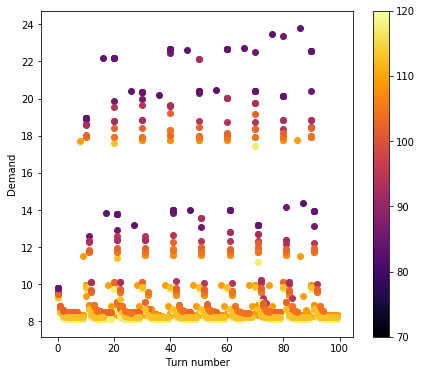

In [10]:
plt.figure(figsize=(7,6))

import matplotlib.colors as mcolors
import matplotlib.cm as cm

normalize = mcolors.Normalize(vmin=70, vmax=120)
colormap = cm.inferno

for i in range(20):
    ix = np.random.choice(len(offer_data))
#     ix = i
    plt.scatter(range(len(offer_data[ix])), offer_data[ix] , 
                color=colormap(normalize(price_reward_data[ix]['learner'][0])))
    
# setup the colorbar
scalarmappaple = cm.ScalarMappable(norm=normalize, cmap=colormap)
scalarmappaple.set_array(range(70,120))
plt.colorbar(scalarmappaple)
plt.xlabel('Turn number')
plt.ylabel('Demand')


Text(0, 0.5, 'Reward')

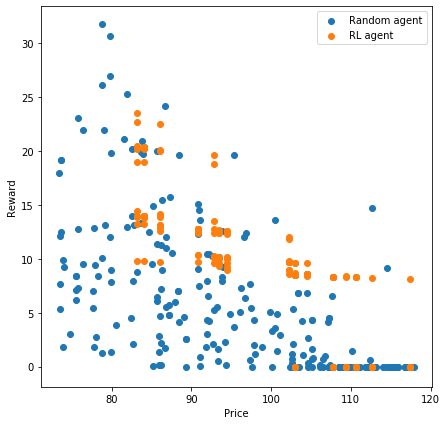

In [11]:
prices = [d['learner'][0] for d in price_reward_data]
rewards = [d['learner'][1] for d in price_reward_data]

scatter = [(d[k][0], d[k][1]) for d in price_reward_data for k in d if k[0] != 'b']
scatter_random_sample = []

for i in range(250):
    scatter_random_sample.append(scatter[np.random.choice(len(scatter))])

prices_other = [s[0] for s in scatter_random_sample]
rewards_other = [s[1] for s in scatter_random_sample]

plt.figure(figsize=(7, 7))
plt.scatter(prices_other, rewards_other, label='Random agent')
plt.scatter(prices, rewards, label='RL agent')
plt.legend()
plt.xlabel('Price')
plt.ylabel('Reward')



In [12]:
sum(rewards) / len(rewards)

8.582609049479167

In [13]:
sum(rewards_other) / len(rewards_other)

5.893496880694407

Text(0, 0.5, 'Reward')

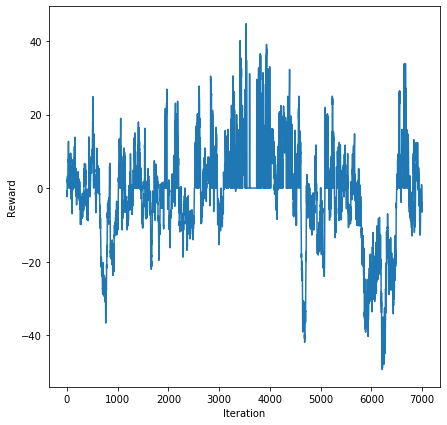

In [14]:
plt.figure(figsize=(7,7))

records = torch.load('results/records_ou2')

flatten = lambda l: [item for sublist in l for item in sublist]

l2 = flatten( records['rewards'])
l3 = [sum(ll) for ll in l2]

plt.plot(l3)
plt.xlabel('Iteration')
plt.ylabel('Reward')


Text(0, 0.5, 'Reward')

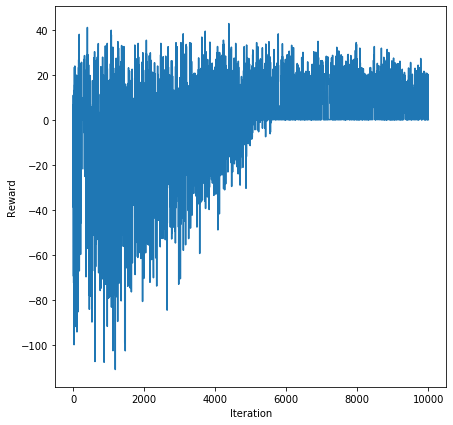

In [15]:
plt.figure(figsize=(7,7))

records = torch.load('results/records2')

flatten = lambda l: [item for sublist in l for item in sublist]

l2 = flatten( records['rewards'])
l3 = [sum(ll) for ll in l2]

plt.plot(l3)
plt.xlabel('Iteration')
plt.ylabel('Reward')
